# Estimate so2 as a function of  financial ratio (add city-level, Estimate by city-industry)

# US Name

Estimate so2 as a function of  financial ratio (add city-level, Estimate by city-industry) 

# Business needs 

Estimate so2 as a function of  financial ratio (Add city-industry financial ratio level, Pull estimate using financial ratio at the city-industry) 

## Description
### Objective 

Test the coefficient sign and significant of the main variable

### Tables

1. Table 1: Baseline Estimate, so2 and financial ratio

**Cautious**
* Make sure no empty rows, otherwise it will be filtered out in the estimate


# Metadata

* Key: srj15wnkj21653b
* Parent key (for update parent):  
* Epic: Models
* US: Sector by sector
* Task tag: #analytics,#econometrics,#sector-estimate
* Notebook US Parent (i.e the one to update): 
https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/02_data_analysis/01_model_estimation/00_estimate_fin_ratio/03_so2_fin_ratio_sector.md
* Reports: https://htmlpreview.github.io/?https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/02_data_analysis/01_model_estimation/00_estimate_fin_ratio/Reports/03_so2_fin_ratio_sector.html
* Analytics reports:
 

# Input Cloud Storage [AWS/GCP]

## Table/file
* Name: 
* fin_dep_pollution_baseline_city
* Github: 
  * https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/04_fin_dep_pol_baseline_city.md



# Connexion server

In [1]:
from awsPy.aws_authorization import aws_connector
from awsPy.aws_s3 import service_s3
from awsPy.aws_glue import service_glue
from pathlib import Path
import pandas as pd
import numpy as np
#import seaborn as sns
import os, shutil, json

path = os.getcwd()
parent_path = str(Path(path).parent.parent.parent)


name_credential = 'financial_dep_SO2_accessKeys.csv'
region = 'eu-west-3'
bucket = 'datalake-datascience'
path_cred = "{0}/creds/{1}".format(parent_path, name_credential)

In [2]:
con = aws_connector.aws_instantiate(credential = path_cred,
                                       region = region)
client= con.client_boto()
s3 = service_s3.connect_S3(client = client,
                      bucket = bucket, verbose = False)
glue = service_glue.connect_glue(client = client) 

In [3]:
pandas_setting = True
if pandas_setting:
    #cm = sns.light_palette("green", as_cmap=True)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_colwidth', None)

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'


# Load tables

Since we load the data as a Pandas DataFrame, we want to pass the `dtypes`. We load the schema from Glue to guess the types

In [5]:
db = 'environment'
table = 'fin_dep_pollution_baseline_city'

In [6]:
dtypes = {}
schema = (glue.get_table_information(database = db,
                           table = table)
          ['Table']['StorageDescriptor']['Columns']
         )
for key, value in enumerate(schema):
    if value['Type'] in ['varchar(12)']:
        format_ = 'string'
    elif value['Type'] in ['decimal(21,5)', 'double', 'bigint', 'int', 'float']:
        format_ = 'float'
    else:
        format_ = value['Type'] 
    dtypes.update(
        {value['Name']:format_}
    )

In [7]:
download_data = True
filename = 'df_{}'.format(table)
full_path_filename = 'SQL_OUTPUT_ATHENA/CSV/{}.csv'.format(filename)
path_local = os.path.join(str(Path(path).parent.parent.parent), 
                              "00_data_catalogue/temporary_local_data")
df_path = os.path.join(path_local, filename + '.csv')
if download_data:
    
    s3 = service_s3.connect_S3(client = client,
                          bucket = bucket, verbose = False)
    query = """
    SELECT * 
    FROM {}.{}
    """.format(db, table)
    df = (s3.run_query(
        query=query,
        database=db,
        s3_output='SQL_OUTPUT_ATHENA',
        filename=filename,  # Add filename to print dataframe
        destination_key='SQL_OUTPUT_ATHENA/CSV',  #Use it temporarily
        dtype = dtypes
    )
            )
    s3.download_file(
        key = full_path_filename
    )
    shutil.move(
        filename + '.csv',
        os.path.join(path_local, filename + '.csv')
    )
    s3.remove_file(full_path_filename)
    df.head()

In [8]:
pd.DataFrame(schema)

,Name,Type,Comment
0,year,string,year from 2001 to 2007
1,period,varchar(5),"False if year before 2005 included, True if year 2006 and 2007"
2,provinces,string,
3,cityen,string,
4,geocode4_corr,string,
...,...,...,...
83,dominated_sales_for_i,"map<double,boolean>","map with information on foreign dominated industry knowing percentile .5, .75, .9, .95 of sales"
84,dominated_capital_for_i,"map<double,boolean>","map with information on foreign dominated industry knowing percentile .5, .75, .9, .95 of capital"
85,fe_c_i,bigint,City industry fixed effect
86,fe_t_i,bigint,year industry fixed effect


## Schema Latex table

To rename a variable, please use the following template:

```
{
    'old':'XX',
    'new':'XX_1'
    }
```

if you need to pass a latex format with `\`, you need to duplicate it for instance, `\text` becomes `\\text:

```
{
    'old':'working\_capital\_i',
    'new':'\\text{working capital}_i'
    }
```

Then add it to the key `to_rename`

In [9]:
add_to_dic = True
if add_to_dic:
    with open('schema_table.json') as json_file:
        data = json.load(json_file)
    data['to_rename'] = []
    dic_rename = [
        ### control variables
        {
        'old':'output',
        'new':'\\text{output}_{cit}'
        },
        {
        'old':'employment',
        'new':'\\text{employment}_{cit}'
        },
        {
        'old':'capital',
        'new':'\\text{capital}_{cit}'
        },
        {
        'old':'sales',
        'new':'\\text{sales}_{cit}'
        },
        {
        'old':'total\_asset',
        'new':'\\text{total asset}_{cit}'
        },
        ### Polluted sector
        {
        'old':'polluted_di',
        'new':'\\text{polluted sector, decile}_{ci}'
        },
        {
        'old':'polluted\_diABOVE',
        'new':'\\text{polluted sector, decile}_{ci}'
        },
        {
        'old':'polluted_mi',
        'new':'\\text{polluted sector, mean}_{ci}'
        },
        {
        'old':'polluted\_miABOVE',
        'new':'\\text{polluted sector, mean}_{ci}'
        },
        {
        'old':'polluted_mei',
        'new':'\\text{polluted sector, median}_{ci}'
        },
        {
        'old':'polluted\_meiABOVE',
        'new':'\\text{polluted sector, median}_{ci}'
        },
        ### financial ratio
        #### Industry
        {
        'old':'credit\_constraint',
        'new':'\\text{credit constraint}_i'
        },
        {
        'old':'std\_receivable\_curasset\_ci',
        'new':'\\text{receivable asset ratio}_{ci}'
        },
        {
        'old':'receivable\_curasset\_ci',
        'new':'\\text{receivable asset ratio}_{ci}'
        },
        {
        'old':'std\_cash\_over\_curasset\_ci',
        'new':'\\text{cash over asset}_{ci}'
        },
        {
        'old':'cash\_over\_curasset\_ci',
        'new':'\\text{cash over asset}_{ci}'
        },  
        {
        'old':'std\_cash_over_totasset_ci',
        'new':'\\text{cash over asset}_{ci}'
        },
        {
        'old':'cash\_over\_totasset\_ci',
        'new':'\\text{cash over asset}_{ci}'
        },
        {
        'old':'std\_working\_capital\_ci',
        'new':'\\text{working capital}_{ci}'
        },
        {
        'old':'working\_capital\_ci',
        'new':'\\text{working capital}_{ci}'
        },
        {
        'old':'std\_working\_capital\_requirement\_ci',
        'new':'\\text{working capital requirement}_{ci}'
        },
        {
        'old':'working\_capital\_requirement\_ci',
        'new':'\\text{working capital requirement}_{ci}'
        },
        {
        'old':'std\_current\_ratio\_ci',
        'new':'\\text{current ratio}_{ci}'
        },
        {
        'old':'current\_ratio\_ci',
        'new':'\\text{current ratio}_{ci}'
        },
        {
        'old':'std\_quick\_ratio\_ci',
        'new':'\\text{quick ratio}_{ci}'
        },
        {
        'old':'quick\_ratio\_ci',
        'new':'\\text{quick ratio}_{ci}'
        },
        {
        'old':'std\_cash\_ratio\_ci',
        'new':'\\text{cash ratio}_{ci}'
        },
        {
        'old':'cash\_ratio\_ci',
        'new':'\\text{cash ratio}_{ci}'
        },
        {
        'old':'std\_liabilities\_assets\_ci',
        'new':'\\text{liabilities assets}_{ci}'
        },{
        'old':'liabilities\_assets\_ci',
        'new':'\\text{liabilities assets}_{ci}'
        },
        {
        'old':'std\_return\_on\_asset\_ci',
        'new':'\\text{return on asset}_{ci}'
        },{
        'old':'return\_on\_asset\_ci',
        'new':'\\text{return on asset}_{ci}'
        },
        {
        'old':'std\_sales\_assets\_ci',
        'new':'\\text{std sales assets}_{ci}'
        },
        {
        'old':'sales\_assets\_ci',
        'new':'\\text{sales assets}_{ci}'
        },
         {
        'old':'std\_sales\_assets\_andersen\_ci',
        'new':'\\text{sales over assets}_{ci}'
        },
        {
        'old':'sales\_assets\_andersen\_ci',
        'new':'\\text{sales over assets}_{ci}'
        },
        {
        'old':'std\_rd\_intensity\_ci',
        'new':'\\text{rd intensity}_{ci}'
        },
        {
        'old':'rd\_intensity\_ci',
        'new':'\\text{rd intensity}_{ci}'
        },
        {
        'old':'std\_inventory\_to\_sales\_ci',
        'new':'\\text{inventory to sales}_{ci}'
        },
        {
        'old':'inventory\_to\_sales\_ci',
        'new':'\\text{inventory to sales}_{ci}'
        },
        {
        'old':'std\_asset\_tangibility\_ci',
        'new':'\\text{asset tangibility}_{ci}'
        },
        {
        'old':'asset\_tangibility\_ci',
        'new':'\\text{asset tangibility}_{ci}'
        },
        {
        'old':'std\_account\_paybable\_to\_asset\_ci',
        'new':'\\text{account paybable to asset}_{ci}'
        },
        {
        'old':'account\_paybable\_to\_asset\_ci',
        'new':'\\text{account paybable to asset}_{ci}'
        },
        {
        'old':'std\_reverse\_liabilities\_assets\_ci',
        'new':'\\text{inverse liabilites to asset}_{ci}'
        },
        {
        'old':'reverse\_liabilities\_assets\_ci',
        'new':'\\text{inverse liabilites to asset}_{ci}'
        },
        #### 
        {
        'old':'periodTRUE',
        'new':'\\text{period}'
        },
        {
        'old':'period',
        'new':'\\text{period}'
        },
        {
        'old':'tso2\_mandate\_c',
        'new':'\\text{policy mandate}_c'
        }
    ]

    data['to_rename'].extend(dic_rename)
    with open('schema_table.json', 'w') as outfile:
        json.dump(data, outfile)

In [10]:
import function.latex_beautify as lb

#%load_ext autoreload
#%autoreload 2

In [11]:
options(warn=-1)
library(tidyverse)
library(lfe)
#library(lazyeval)
library('progress')
path = "function/table_golatex.R"
source(path)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1       ✔ purrr   0.3.2  
✔ tibble  2.1.1       ✔ dplyr   0.8.0.1
✔ tidyr   0.8.3       ✔ stringr 1.4.0  
✔ readr   1.3.1       ✔ forcats 0.4.0  
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: Matrix

Attaching package: ‘Matrix’

The following object is masked from ‘package:tidyr’:

    expand


Please cite as: 

 Hlavac, Marek (2018). stargazer: Well-Formatted Regression and Summary Statistics Tables.
 R package version 5.2.2. https://CRAN.R-project.org/package=stargazer 



In [12]:
%get df_path
df_final <- read_csv(df_path) %>%
mutate_if(is.character, as.factor) %>%
    mutate_at(vars(starts_with("fe")), as.factor) %>%
mutate(
    period = relevel(as.factor(period), ref='FALSE'),
    polluted_di = relevel(as.factor(polluted_di), ref='BELOW'),
    polluted_mi = relevel(as.factor(polluted_mi), ref='BELOW'),
    polluted_mei = relevel(as.factor(polluted_mei), ref='BELOW'),
    #working_capital_i = working_capital_i /1000000,
    #working_capital_requirement_i = working_capital_requirement_i /1000000,
    #liabilities_assets_m2_i = liabilities_assets_m2_i /1000000,
    #asset_tangibility_i = asset_tangibility_i /1000000,
    #polluted_thre = relevel(as.factor(polluted_thre), ref='BELOW'),
    
)

Parsed with column specification:
cols(
  .default = col_double(),
  period = col_logical(),
  provinces = col_character(),
  cityen = col_character(),
  short = col_character(),
  polluted_di = col_character(),
  polluted_mi = col_character(),
  polluted_mei = col_character(),
  above_threshold_mandate = col_character(),
  above_average_mandate = col_character(),
  lower_location = col_character(),
  larger_location = col_character(),
  coastal = col_character(),
  dominated_output_soe_c = col_character(),
  dominated_employment_soe_c = col_character(),
  dominated_sales_soe_c = col_character(),
  dominated_capital_soe_c = col_character(),
  dominated_output_for_c = col_character(),
  dominated_employment_for_c = col_character(),
  dominated_sales_for_c = col_character(),
  dominated_capital_for_c = col_character()
  # ... with 16 more columns
)
See spec(...) for full column specifications.


# Expected signs

| index | Metrics                        | comments                                                                                                    | variables                                                                                                                                                           | Roam_link                                       | Exepected sign              | Comment                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
|-------|--------------------------------|-------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------|-------------------------------------------------|-----------------------------|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1     | External finance dependence    | From #[[Fan et al. 2015 - Credit constraints, quality, and export prices - Theory and evidence from China]] |                                                                                                                                                                     | #external-finance-dependence                    | Negative                    | An industry’s external finance dependence (ExtFini) is defined as the share of capital expenditure not financed with cash flows from operations. If external finance dependence is high, the industry is more financially vulnerable and have higher credit needs                                                                                                                                                                                                                                                                              |
| 2     | R&D intensity                  | RD / Sales                                                                                                  | rdfee/sales                                                                                                                                                         | #rd-intensity                                   | Negative                    | Share of RD expenditure over sales. larger values indicates larger use of sales to spend on RD. Say differently, lower borrowing done toward RD                                                                                                                                                                                                                                                                                                                                                                                                |
| 3     | Inventory to sales             | Inventory / sales                                                                                           | 存货 (c81) / sales                                                                                                                                                  | #inventory-to-sales                             | Negative                    | Share of inventory over sales. Larger values indicates share of unsold or not consumed items. large values is a demonstration of tighter credit constraint                                                                                                                                                                                                                                                                                                                                                                                     |
| 4     | % receivable                   | receivable account / current asset                                                                          | 应收帐款 (c80) / cuasset                                                                                                                                            | #account-receivable #current-asset              | Negative                    | Share of receivable over current asset. Larger value indicates longer time before collecting the money from the customers                                                                                                                                                                                                                                                                                                                                                                                                                      |
| 5     | Liabilities over asset         | (Short-Tern Debt + Long-Term Debt)/total asset                                                              | (流动负债合计 (c95) + 长期负债合计 (c97)) / toasset                                                                                                                 | #total-debt-to-total-assets                     | Negative                    | Share of liabilities over total asset. Larger value indicates assets that are financed by external creditors                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| 6     | working capital requirement    | Inventory + Accounts receivable - Accounts payable                                                          | 存货 (c81) + 应收帐款 (c80) - 应付帐款  (c96)                                                                                                                       | #working-capital                                | Negative                    | Working Capital Requirement is the amount of money needed to finance the gap between disbursements (payments to suppliers) and receipts (payments from customers). Larger values indicate the amount of money needed to meet the debt.                                                                                                                                                                                                                                                                                                         |
| 7     | % cash                         | Current asset - cash / current asset                                                                        | (cuasset- 其中：短期投资 (c79) - 应收帐款 (c80) - 存货 (c81) - 其中：产成品 (c82)) /current asset                                                                   | #current-asset #cash                            | Positive                    | Share of cash asset over current asset. Larger values indicate more cash in hand.                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
|       | Cash over asset                | Current asset - cash / total asset                                                                          | (cuasset- 其中：短期投资 (c79) - 应收帐款 (c80) - 存货 (c81) - 其中：产成品 (c82)) /toasset                                                                         | #current-asset #cash                            | Positive                    | Share of cash asset over total asset. Larger values indicate more cash in hand.                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| 8     | cash ratio                     | (Cash + marketable securities)/current liabilities                                                          | 1-(cuasset - 其中：短期投资 (c79) - 应收帐款 (c80) - 存货 (c81) - 其中：产成品 (c82))/ 流动负债合计 (c95)                                                           | #cash-asset #cash-ratio                         | Positive                    | Cash divided by liabilities. A portion of short-term debt that can be financed by cash. A larger value indicates the company generates enough cash to cope with the short term debt                                                                                                                                                                                                                                                                                                                                                            |
| 9     | Working capital                | Current asset - current liabilities                                                                         | cuasset- 流动负债合计 (c95)                                                                                                                                         | #working-capital-requirement                    | Positive                    | Difference between current asset and current liabilities. Larger value indicates that assets are enough to cope with the short term need                                                                                                                                                                                                                                                                                                                                                                                                       |
| 10    | current ratio                  | Current asset /current liabilities                                                                          | cuasset/流动负债合计 (c95)                                                                                                                                          | #current-ratio                                  | Ambiguous                   | Asset divided by liabilities. Values above 1 indicate there are more assets than liabilities. There are two effects on the liquidity constraint. Larger values imply the company has more liquidity, hence they may be less dependent on the formal financial market. By analogy, the financial market prefers to invest or provide money to the more liquid company (reduce the risk default)                                                                                                                                                 |
| 11    | Quick ratio                    | (Current asset - Inventory)/current liabilities                                                             | (cuasset -  其中：短期投资 (c79) - 应收帐款 (c80) - 存货 (c81)) / 流动负债合计 (c95)                                                                                | #quick-ratio                                    | Ambiguous                   | The quick ratio is a measure of liquidity. The higher the more liquid the company is. To improve the ratio, the company should reduce the account receivable (reduce payment time) and increase the account payable (negotiate payment term). There are two effects on the liquidity constraint. Larger values imply the company has more liquidity, hence they may be less dependent on the formal financial market. By analogy, the financial market prefers to invest or provide money to the more liquid company (reduce the risk default) |
| 12    | Return on Asset                | Net income / Total assets                                                                                   | sales - (主营业务成本 (c108) + 营业费用 (c113) + 管理费用 (c114) + 财产保险费 (c116) + 劳动、失业保险费 (c118)+ 财务费用 (c124) + 本年应付工资总额 (wage)) /toasset | #return-on-asset                                | Ambiguous                   | Net income over total asset. Capacity of an asset to generate income. Larger value indicates that asset are used in an efficiente way to generate income                                                                                                                                                                                                                                                                                                                                                                                       |
| 13    | Asset Turnover Ratio           | Total sales / ((delta total asset)/2)                                                                       | 全年营业收入合计 (c64) /($\Delta$ toasset/2)                                                                                                                        | #asset-turnover-ratio                           | Ambiguous                   | Sales divided by the average changes in total asset. Larger value indicates better efficiency at using asset to generate revenue                                                                                                                                                                                                                                                                                                                                                                                                               |
| 14    | Sale over asset                | Total sales /total asset                                                                                    | 全年营业收入合计 (c64) /(toasset)                                                                                                                                   | #sale-over-asset                                | Ambiguous                   | Sales divided by total asset. Larger value indicates better efficiency at using asset to generate revenue                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| 15    | Asset tangibility              | Total fixed assets - Intangible assets                                                                      | tofixed - 无形资产 (c92)                                                                                                                                            | #asset-tangibility                              | Ambiguous                   | Difference between fixed sset and intangible asset. Larger value indicates more collateral, hence higher borrowing capacity                                                                                                                                                                                                                                                                                                                                                                                                                    |
| 16    | Account payable to total asset | (delta account payable)/ (delta total asset)                                                                | ($\Delta$ 应付帐款  (c96))/ ($\Delta$$ (toasset))                                                                                                                   | #change-account-paybable-to-change-total-assets | Ambiguous (favour positive) | Variation of account payable over variation total asset. If the nominator larger than the denominator, it means the account payable grew larger than an asset, or more time is given to pay back the supplier relative to the total asset.  Say differently,  companies can more easily access buyer or supplier trade credit, they may be less dependent on the formal financial market                                                                                                                                                       |

## Table 1: Determinant of SO2 emission: so2 and financial ratio

$$ \begin{aligned} \text{SO2}{cit} &= \alpha \text{Financial ratio}_{ci} + \text{X}_{cit} + \gamma{c} + \gamma{t} + \epsilon_{cit} \end{aligned} $$

**Andersen results**

![](https://drive.google.com/uc?export=view&id=1HrqaA5NLRPjWk2lqvHyrZAjO3wSP5r-9)


### Reproduce Andersen Table

In [13]:
folder = 'Tables_0'
table_nb = 1
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]

In [14]:
%get path table
t_0 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)
t_2 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

t_3 <- felm(log(so2_intensity) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)
t_4 <- felm(log(so2_intensity) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)
t_5 <- felm(log(so2_intensity) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final,
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Determinant of SO2 emission, financial ratio",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

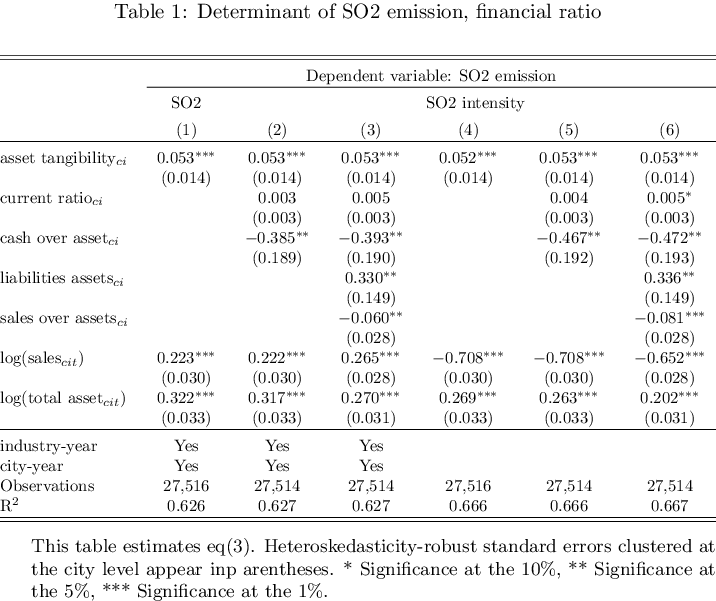

In [15]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 1,
    'SO2 intensity': 5
}

#reorder = {
    
#    7:0,
#    8:1,
    #9:2
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

# Table 2:S02 emission reduction, financial ratio, Filter polluted sector

$$
\begin{aligned}
\text{SO2}_{cit}  &= \alpha \text{Financial ratio}_{ci} + \gamma_{ct} + \gamma_{ci}  + \epsilon_{cit}
\end{aligned}
$$

In [16]:
table_nb = 2
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]
path

'Tables_0/table_2.txt'

In [17]:
%get path table
t_0 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'ABOVE'),
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'ABOVE'),
            exactDOF = TRUE)
t_2 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'ABOVE'),
            exactDOF = TRUE)

t_3 <- felm(log(so2_intensity) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'ABOVE'),
            exactDOF = TRUE)
t_4 <- felm(log(so2_intensity) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'ABOVE'),
            exactDOF = TRUE)
t_5 <- felm(log(so2_intensity) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'ABOVE'),
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Baseline estimate, S02 emission reduction, financial ratio, Filter polluted sector",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

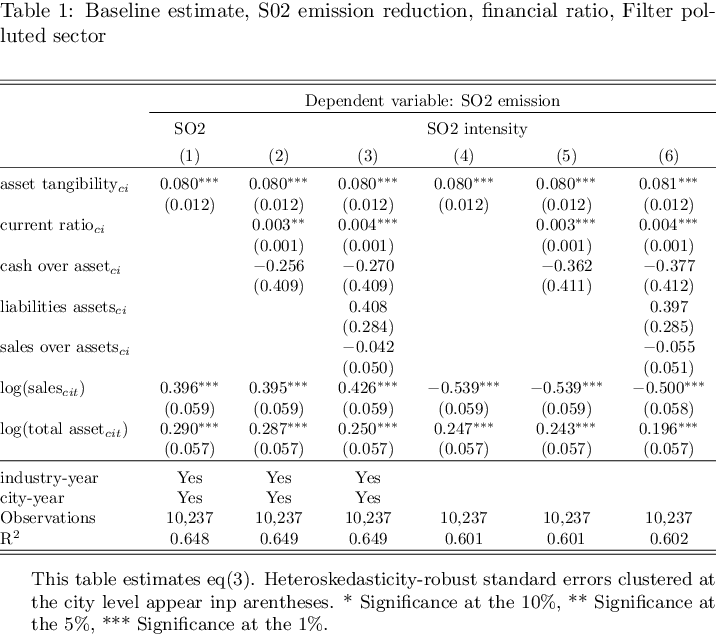

In [18]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 1,
    'SO2 intensity': 5
}

#reorder = {
    
#    7:0,
#    8:1,
    #9:2
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

# Table 3: S02 emission reduction, financial ratio, Filter no polluted sector

$$
\begin{aligned}
\text{SO2}_{cit}  &= \alpha \text{Financial ratio}_ci \times \text{Period} + \gamma_{c} + \gamma_{t}  + \epsilon_{cit}
\end{aligned}
$$

In [19]:
table_nb = 4
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]
path

'Tables_0/table_4.txt'

In [20]:
%get path table
t_0 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'BELOW'),
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'BELOW'),
            exactDOF = TRUE)
t_2 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'BELOW'),
            exactDOF = TRUE)

t_3 <- felm(log(so2_intensity) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'BELOW'),
            exactDOF = TRUE)
t_4 <- felm(log(so2_intensity) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'BELOW'),
            exactDOF = TRUE)
t_5 <- felm(log(so2_intensity) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(polluted_di == 'BELOW'),
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Baseline estimate, S02 emission reduction, financial ratio, Filter no polluted sector",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

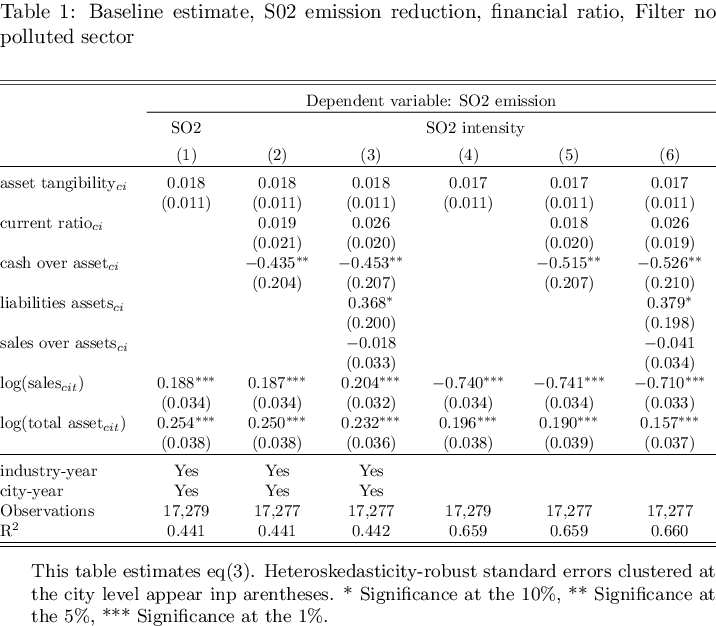

In [21]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 1,
    'SO2 intensity': 5
}

#reorder = {
    
#    7:0,
#    8:1,
    #9:2
#}

#multi_lines_dep = '(city/product/trade regime/year)'
#new_r = ['& test1', 'test2']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            #new_row= new_r,
            multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

# Table 4: Heterogeneity effect, city ownership public vs private

City ownership are available for the following variables:

- output
- capital
- employment
- sales

**How is it constructed** 

1. From the firms table, Aggregate output, employment, capital and sales by firm-city (use all years to get all city sample)
2. Compute the percentile .5, .75, .90,.95
3. Compute dominated city for each percentile
  1. If public > private then public else private
  2. If foreign > domestic then foreign else domestic
  
In our computation, .5 means the median output [employment, capital and sales] for a firm with ownership SOE or Private. If the median output value for a given SOE firm is above the output value of a given private firm, then the sector is labeled as 'Dominated' by SOE

In [22]:
table_nb = 5
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]
path

'Tables_0/table_5.txt'

In [23]:
%get path table

df_temp_true = df_final %>% 
mutate(filter_ = str_extract(dominated_output_soe_c, "(?<=0.5\\=)(.*?)(?=\\,)"))%>%
filter(filter_ == 'true')
df_temp_false = df_final %>% 
mutate(filter_ = str_extract(dominated_output_soe_c, "(?<=0.5\\=)(.*?)(?=\\,)"))%>%
filter(filter_ == 'false')

t_0 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_temp_false,
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_3 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_false,
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_5 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_false,
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title=" Heterogeneity effect, city ownership public vs private (output)",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

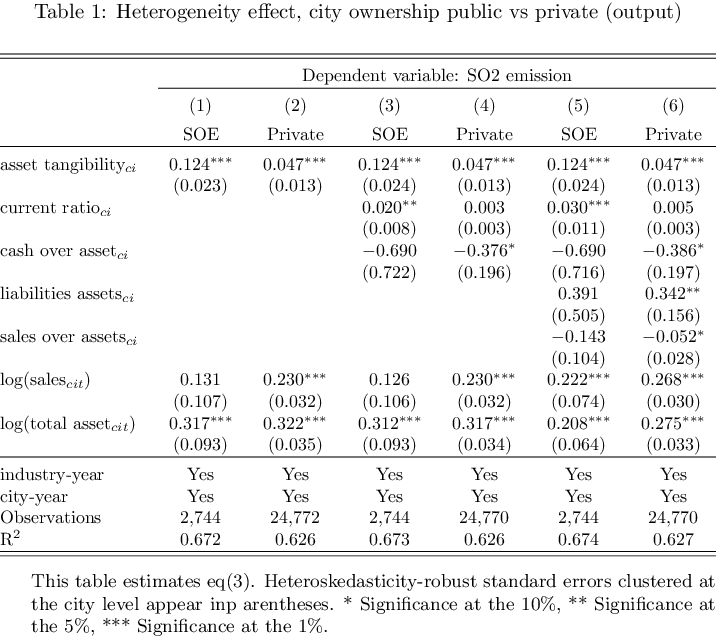

In [24]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 1,
    'SO2 intensity': 5
}

#reorder = {
    
#    7:0,
#    8:1,
    #9:2
#}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& SOE', 'Private', 'SOE', 'Private', 'SOE', 'Private']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

# Table 5: Heterogeneity effect, TCZ vs No TCZ and SPZ vs No SPZ

## TCZ

In [25]:
table_nb = 6
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]
path

'Tables_0/table_6.txt'

In [26]:
%get path table

t_0 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final %>% filter(tcz == 1),
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final %>% filter(tcz == 0),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(tcz == 1),
            exactDOF = TRUE)
t_3 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(tcz == 0),
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(tcz == 1),
            exactDOF = TRUE)
t_5 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(tcz == 0),
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Heterogeneity effect, TCZ vs No TCZ",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

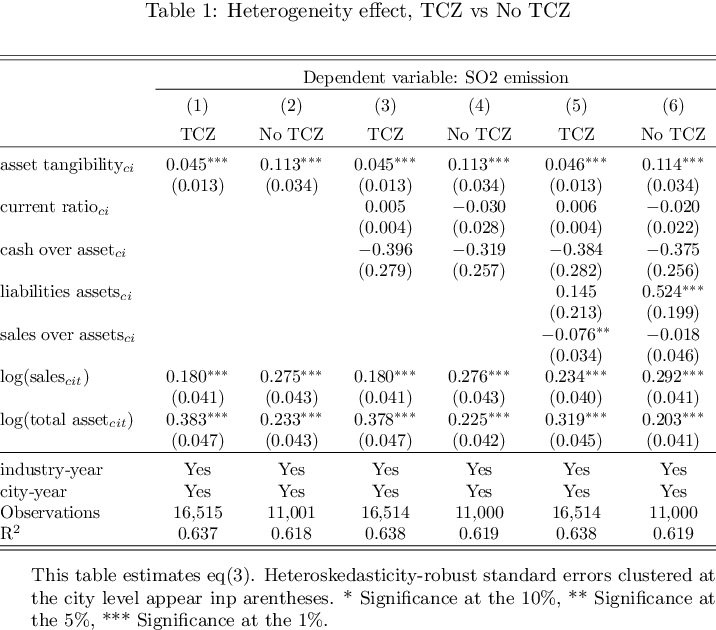

In [27]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 1,
    'SO2 intensity': 5
}

#reorder = {
    
#    7:0,
#    8:1,
    #9:2
#}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& TCZ', 'No TCZ', 'TCZ', 'No TCZ', 'TCZ', 'No TCZ']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

## SPZ

In [28]:
table_nb = 7
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]
path

'Tables_0/table_7.txt'

In [29]:
%get path table

t_0 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final %>% filter(spz == 1),
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_final %>% filter(spz == 0),
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(spz == 1),
            exactDOF = TRUE)
t_3 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(spz == 0),
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(spz == 1),
            exactDOF = TRUE)
t_5 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_final %>% filter(spz == 0),
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Heterogeneity effect, SPZ vs No SPZ",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

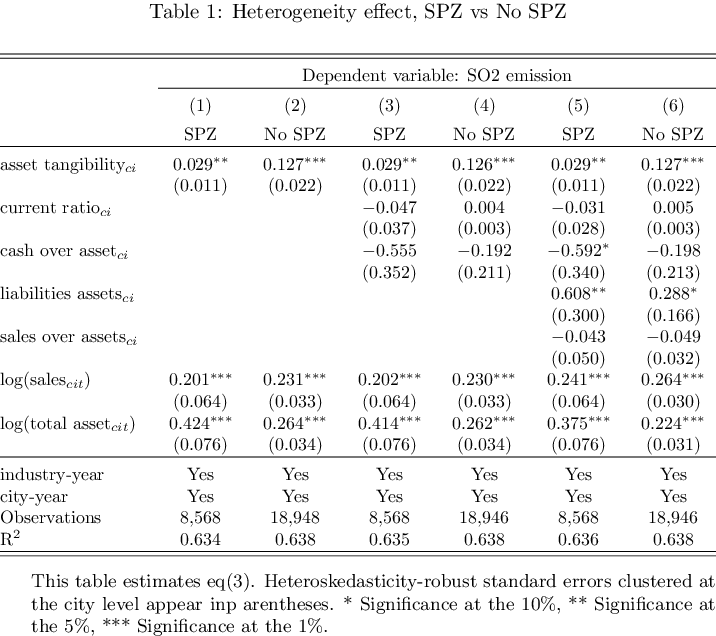

In [30]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 1,
    'SO2 intensity': 5
}

#reorder = {
    
#    7:0,
#    8:1,
    #9:2
#}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& SPZ', 'No SPZ', 'SPZ', 'No SPZ', 'SPZ', 'No SPZ']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

# Table 6: Heterogeneity effect,  Industrial size effect

Industrial are available for the following variables:

- output
- capital
- employment
- sales

- Aggregate output, employment, capital and sales by industry (use 2000)
    - Compute the percentile .5, .75, .90,.95
    - Compute dominated city for each percentile
    - If public > private then public else private
    - If foreign > domestic then foreign else domestic

The notebook reference is the following https://github.com/thomaspernet/Financial_dependency_pollution/blob/master/01_data_preprocessing/02_transform_tables/07_dominated_city_ownership.md#steps-1

A dominated sector is defined as positive when the average output of the firms is above the cross secteur average

- Compute the firm’s industrial output average
- Compute the firm’s national median
  
In our computation, .5 means the median output [employment, capital and sales] for a firm in industry $k$. If the median output value for firm in industry $k$ is above the output value of the national median, then the sector is labeled as 'Large'

In [31]:
table_nb = 8
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]
path

'Tables_0/table_8.txt'

In [32]:
%get path table

df_temp_true = df_final %>% 
mutate(filter_ = str_extract(dominated_output_i, "(?<=0.5\\=)(.*?)(?=\\,)"))%>%
filter(filter_ == 'true')
df_temp_false = df_final %>% 
mutate(filter_ = str_extract(dominated_output_i, "(?<=0.5\\=)(.*?)(?=\\,)"))%>%
filter(filter_ == 'false')

t_0 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_temp_false,
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_3 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_false,
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_5 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_false,
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Heterogeneity effect,  Industrial size effect (output)",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

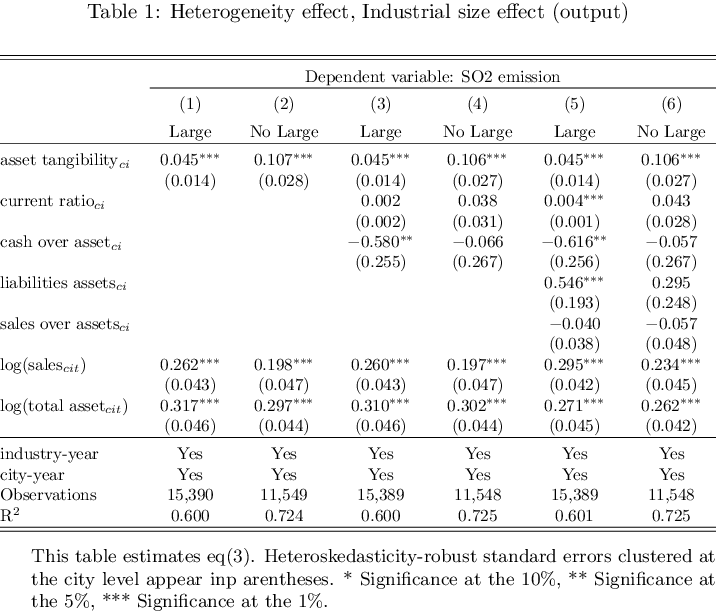

In [33]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 1,
    'SO2 intensity': 5
}

#reorder = {
    
#    7:0,
#    8:1,
    #9:2
#}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Large', 'No Large', 'Large', 'No Large', 'Large', 'No Large']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

# Table 7: Heterogeneity effect, city policy mandate threshold

In [34]:
table_nb = 9
table = 'table_{}'.format(table_nb)
path = os.path.join(folder, table + '.txt')
if os.path.exists(folder) == False:
        os.mkdir(folder)
for ext in ['.txt', '.tex', '.pdf']:
    x = [a for a in os.listdir(folder) if a.endswith(ext)]
    [os.remove(os.path.join(folder, i)) for i in x]
path

'Tables_0/table_9.txt'

In [35]:
%get path table

df_temp_true = df_final %>% 
mutate(filter_ = str_extract(above_threshold_mandate, "(?<=0.5\\=)(.*?)(?=\\,)"))%>%
filter(filter_ == 'true')
df_temp_false = df_final %>% 
mutate(filter_ = str_extract(above_threshold_mandate, "(?<=0.5\\=)(.*?)(?=\\,)"))%>%
filter(filter_ == 'false')

t_0 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_1 <- felm(log(tso2) ~ asset_tangibility_ci  +
            log(sales) + log(total_asset)
            | fe_t_i + fe_c_t|0 | geocode4_corr, df_temp_false,
            exactDOF = TRUE)

t_2 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_3 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr,df_temp_false,
            exactDOF = TRUE)

t_4 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_true,
            exactDOF = TRUE)
t_5 <- felm(log(tso2) ~ asset_tangibility_ci  + current_ratio_ci + cash_over_totasset_ci + liabilities_assets_ci + sales_assets_andersen_ci +
            log(sales) + log(total_asset)
            | fe_t_i +fe_c_t|0 | geocode4_corr, df_temp_false,
            exactDOF = TRUE)

dep <- "Dependent variable: SO2 emission"
fe1 <- list(
    c("industry-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes"),
    c("city-year", "Yes", "Yes", "Yes", "Yes", "Yes", "Yes")
             )
table_1 <- go_latex(list(
    t_0,t_1, t_2, t_3, t_4, t_5
),
    title="Heterogeneity effect, city policy mandate threshold (median)",
    dep_var = dep,
    addFE=fe1,
    save=TRUE,
    note = FALSE,
    name=path
)

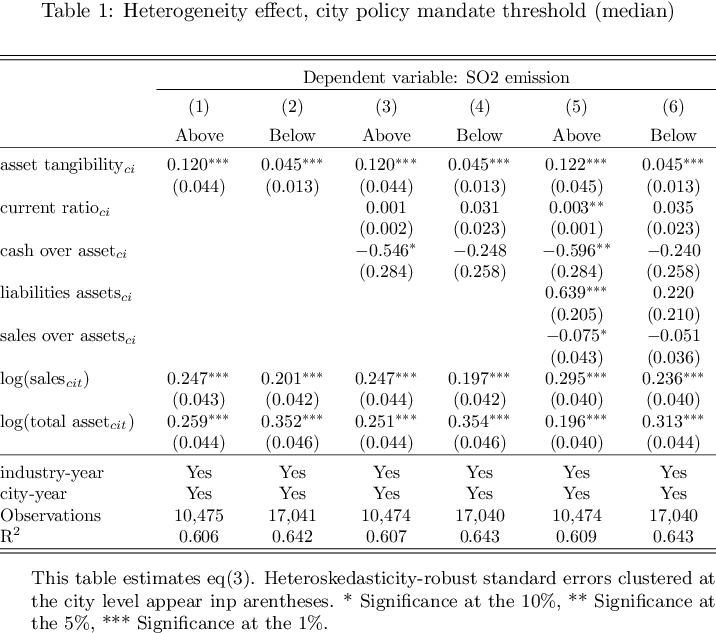

In [36]:
tbe1  = "This table estimates eq(3). " \
"Heteroskedasticity-robust standard errors " \
"clustered at the city level appear inp arentheses. "\
"\sym{*} Significance at the 10\%, \sym{**} Significance at the 5\%, \sym{***} Significance at the 1\%."

multicolumn ={
    'SO2': 1,
    'SO2 intensity': 5
}

#reorder = {
    
#    7:0,
#    8:1,
    #9:2
#}

#multi_lines_dep = '(city/product/trade regime/year)'
new_r = ['& Above', 'Below', 'Above', 'Below', 'Above', 'Below']
lb.beautify(table_number = table_nb,
            #reorder_var = reorder,
            #multi_lines_dep = multi_lines_dep,
            new_row= new_r,
            #multicolumn = multicolumn,
            table_nte = tbe1,
            jupyter_preview = True,
            resolution = 150,
           folder = folder)

# Generate reports

In [37]:
import os, time, shutil, urllib, ipykernel, json
from pathlib import Path
from notebook import notebookapp

In [38]:
def create_report(extension = "html", keep_code = False, notebookname = None):
    """
    Create a report from the current notebook and save it in the 
    Report folder (Parent-> child directory)
    
    1. Exctract the current notbook name
    2. Convert the Notebook 
    3. Move the newly created report
    
    Args:
    extension: string. Can be "html", "pdf", "md"
    
    
    """
    
    ### Get notebook name
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[0].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+ \
                                             'api/sessions?token=' + \
                                             srv['token'])
            sessions = json.load(req)
            notebookname = sessions[0]['name']
        except:
            notebookname = notebookname  
    
    sep = '.'
    path = os.getcwd()
    #parent_path = str(Path(path).parent)
    
    ### Path report
    #path_report = "{}/Reports".format(parent_path)
    #path_report = "{}/Reports".format(path)
    
    ### Path destination
    name_no_extension = notebookname.split(sep, 1)[0]
    source_to_move = name_no_extension +'.{}'.format(extension)
    dest = os.path.join(path,'Reports', source_to_move)
    
    ### Generate notebook
    if keep_code:
        os.system('jupyter nbconvert --to {} {}'.format(
    extension,notebookname))
    else:
        os.system('jupyter nbconvert --no-input --to {} {}'.format(
    extension,notebookname))
    
    ### Move notebook to report folder
    #time.sleep(5)
    shutil.move(source_to_move, dest)
    print("Report Available at this adress:\n {}".format(dest))

In [ ]:
create_report(extension = "html", keep_code = False, notebookname = "03_so2_fin_ratio_sector.ipynb")